In [75]:
!pip install scikit-learn==1.4.2

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [77]:
df=pd.read_csv("final_preprocessed_biat_data.csv")

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346448 entries, 0 to 346447
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   REFERENCE_OPERATION_T24  346448 non-null  object 
 1   CLIENT_ID                346448 non-null  object 
 2   BOOKING_DATE             346448 non-null  object 
 3   DESCRIPTION_OPERATION    346448 non-null  object 
 4   EXCHANGE_RATE            346448 non-null  float64
 5   AMOUNT_FCY               346448 non-null  float64
 6   AMOUNT_LCY               346448 non-null  float64
 7   SENS                     346448 non-null  object 
 8   CURRENCY                 346448 non-null  object 
 9   MT_TND                   346448 non-null  float64
 10  MT_DEVISE                346448 non-null  float64
 11  COURS_MARCHE             346448 non-null  float64
 12  NATURE_CLIENT            346448 non-null  object 
 13  MARGE_PNDR               346448 non-null  float64
 14  MATR

In [79]:
df['BOOKING_DATE'] = pd.to_datetime(df['BOOKING_DATE'])
df['AJOUTE_LE'] = pd.to_datetime(df['AJOUTE_LE'])

In [80]:
def feature_engineering(df):

    df = df.sort_values(['CLIENT_ID', 'BOOKING_DATE'])
    df['NEXT_BOOKING_DATE'] = df.groupby('CLIENT_ID')['BOOKING_DATE'].shift(-1)
    df['DAYS_TO_NEXT'] = (df['NEXT_BOOKING_DATE'] - df['BOOKING_DATE']).dt.days

    # Temporal features
    df['YEAR'] = df['BOOKING_DATE'].dt.year
    df['MONTH'] = df['BOOKING_DATE'].dt.month
    df['DAY'] = df['BOOKING_DATE'].dt.day
    df['DAY_OF_WEEK'] = df['BOOKING_DATE'].dt.dayofweek
    df['WEEK_OF_YEAR'] = df['BOOKING_DATE'].dt.isocalendar().week
    df['IS_MONTH_START'] = df['BOOKING_DATE'].dt.is_month_start.astype(int)
    df['IS_MONTH_END'] = df['BOOKING_DATE'].dt.is_month_end.astype(int)
    
    # Time-based features
    df['DAYS_SINCE_ACCT_CREATION'] = (df['BOOKING_DATE'] - df['AJOUTE_LE']).dt.days
    df['DAYS_SINCE_LAST_TX'] = df.groupby('CLIENT_ID')['BOOKING_DATE'].diff().dt.days
    
    
    # Financial features
    df['AMOUNT_RATIO'] = df['AMOUNT_FCY'] / df['AMOUNT_LCY']
    df['EXCHANGE_DIFF'] = df['EXCHANGE_RATE'] - df['COURS_MARCHE']
    df['AMOUNT_SIGN'] = np.where(df['SENS'] == 'A', 1, -1)
    df['AMOUNT_SIZE'] = np.log1p(np.abs(df['AMOUNT_LCY']))
    
    
    # Client-level aggregations
    client_agg = df.groupby('CLIENT_ID').agg({
        'AMOUNT_LCY': ['mean', 'std', 'sum', 'min', 'max'],
        'DAYS_SINCE_LAST_TX': ['mean', 'std'],
        'BOOKING_DATE': ['min', 'max', 'count']
    })
    client_agg.columns = ['CLIENT_' + '_'.join(col).strip() for col in client_agg.columns.values]
    client_agg = client_agg.reset_index()
    
    # Merge client features
    df = pd.merge(df, client_agg, on='CLIENT_ID', how='left')
    
    # Group-level aggregations
    group_agg = df.groupby('NOM_GROUPE').agg({
        'AMOUNT_LCY': ['mean', 'median'],
        'DAYS_TO_NEXT': ['mean', 'median']
    })
    group_agg.columns = ['GROUP_' + '_'.join(col).strip() for col in group_agg.columns.values]
    group_agg = group_agg.reset_index()
    
    # Merge group features
    df = pd.merge(df, group_agg, on='NOM_GROUPE', how='left')
    
    # Segment-level aggregations
    segment_agg = df.groupby('SEGMENTS').agg({
        'DAYS_TO_NEXT': ['mean', 'median']
    })
    segment_agg.columns = ['SEGMENT_' + '_'.join(col).strip() for col in segment_agg.columns.values]
    segment_agg = segment_agg.reset_index()
    
    # Merge segment features
    df = pd.merge(df, segment_agg, on='SEGMENTS', how='left')
    
    return df

In [81]:
df=feature_engineering(df)

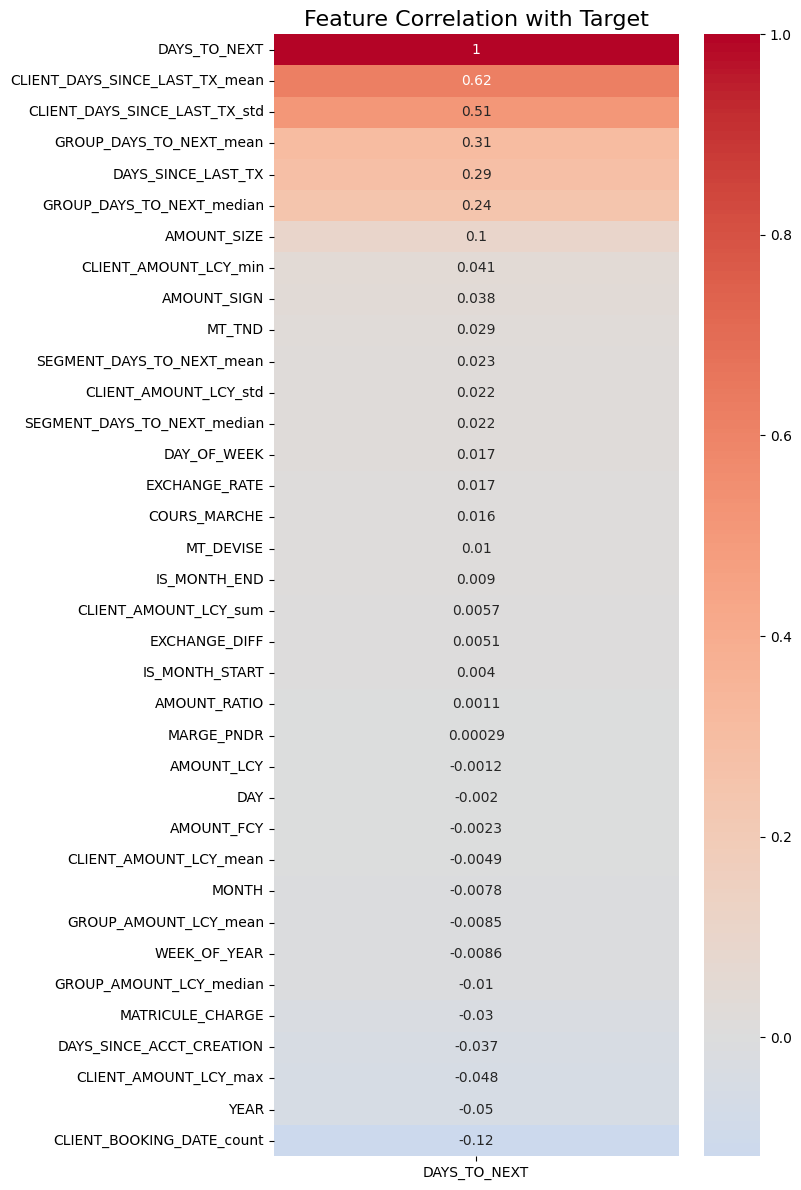

In [82]:
# Visualize feature correlations
corr_matrix = df.corr(numeric_only=True)[['DAYS_TO_NEXT']].sort_values('DAYS_TO_NEXT', ascending=False)
plt.figure(figsize=(8, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with Target', fontsize=16)
plt.tight_layout()
plt.savefig('feature_correlation.png')
plt.show()

In [83]:
# Categorical encoding
def encode_categorical(df):
    # Low-cardinality features
    cat_cols = ['SENS', 'CURRENCY', 'NATURE_CLIENT', 'DIRECTION', 'SEGMENTS']
    
    # Label encoding for high-cardinality features
    for col in ['DESCRIPTION_OPERATION', 'NOM_GROUPE']:
        le = LabelEncoder()
        df[col + '_ENCODED'] = le.fit_transform(df[col].astype(str))
        cat_cols.append(col + '_ENCODED')
    
    return df, cat_cols

df, categorical_features = encode_categorical(df)


In [84]:
# assuming you already sorted by ['CLIENT_ID','BOOKING_DATE']
first_tx = df.groupby('CLIENT_ID')['BOOKING_DATE'].rank(method='first') == 1

# start with median per client
df['DAYS_SINCE_LAST_TX'] = (
    df.groupby('CLIENT_ID')['DAYS_SINCE_LAST_TX']
      .transform(lambda s: s.fillna(s.median()))
)

# then force first transaction gap to 0
df.loc[first_tx, 'DAYS_SINCE_LAST_TX'] = 0


c:\Users\someb\Downloads\Stage\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\someb\Downloads\Stage\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\someb\Downloads\Stage\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\someb\Downloads\Stage\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\someb\Downloads\Stage\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\someb\Downloads\Stage\venv\Lib\site-packages\numpy\lib\_nanfunctio

In [86]:
keep_cols = [
    'DAYS_TO_NEXT','BOOKING_DATE','DAYS_SINCE_LAST_TX','AMOUNT_LCY','CLIENT_ID',
    'EXCHANGE_DIFF','AMOUNT_RATIO','CLIENT_AMOUNT_LCY_mean','CLIENT_BOOKING_DATE_count',
    'GROUP_AMOUNT_LCY_mean','SEGMENT_DAYS_TO_NEXT_mean','DAYS_SINCE_ACCT_CREATION',
    'DESCRIPTION_OPERATION_ENCODED','NOM_GROUPE_ENCODED','DAY_OF_WEEK','WEEK_OF_YEAR'
] + ['SENS','CURRENCY','NATURE_CLIENT','DIRECTION','SEGMENTS']  # not the encoded ones again

# de-duplicate while preserving order
keep_cols = list(dict.fromkeys(keep_cols))
df = df[keep_cols]


In [87]:
df = df[df['DAYS_TO_NEXT'].notna()].copy()

In [88]:
df.isna().sum()

DAYS_TO_NEXT                     0
BOOKING_DATE                     0
DAYS_SINCE_LAST_TX               0
AMOUNT_LCY                       0
CLIENT_ID                        0
EXCHANGE_DIFF                    0
AMOUNT_RATIO                     0
CLIENT_AMOUNT_LCY_mean           0
CLIENT_BOOKING_DATE_count        0
GROUP_AMOUNT_LCY_mean            0
SEGMENT_DAYS_TO_NEXT_mean        0
DAYS_SINCE_ACCT_CREATION         0
DESCRIPTION_OPERATION_ENCODED    0
NOM_GROUPE_ENCODED               0
DAY_OF_WEEK                      0
WEEK_OF_YEAR                     0
SENS                             0
CURRENCY                         0
NATURE_CLIENT                    0
DIRECTION                        0
SEGMENTS                         0
dtype: int64

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345448 entries, 2 to 346446
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   DAYS_TO_NEXT                   345448 non-null  float64       
 1   BOOKING_DATE                   345448 non-null  datetime64[ns]
 2   DAYS_SINCE_LAST_TX             345448 non-null  float64       
 3   AMOUNT_LCY                     345448 non-null  float64       
 4   CLIENT_ID                      345448 non-null  object        
 5   EXCHANGE_DIFF                  345448 non-null  float64       
 6   AMOUNT_RATIO                   345448 non-null  float64       
 7   CLIENT_AMOUNT_LCY_mean         345448 non-null  float64       
 8   CLIENT_BOOKING_DATE_count      345448 non-null  int64         
 9   GROUP_AMOUNT_LCY_mean          345448 non-null  float64       
 10  SEGMENT_DAYS_TO_NEXT_mean      345448 non-null  float64       
 11  DAYS_

In [90]:
df.head()

,DAYS_TO_NEXT,BOOKING_DATE,DAYS_SINCE_LAST_TX,AMOUNT_LCY,CLIENT_ID,EXCHANGE_DIFF,AMOUNT_RATIO,CLIENT_AMOUNT_LCY_mean,CLIENT_BOOKING_DATE_count,GROUP_AMOUNT_LCY_mean,...,DAYS_SINCE_ACCT_CREATION,DESCRIPTION_OPERATION_ENCODED,NOM_GROUPE_ENCODED,DAY_OF_WEEK,WEEK_OF_YEAR,SENS,CURRENCY,NATURE_CLIENT,DIRECTION,SEGMENTS
2,24.0,2021-05-25,0.0,-18565.0150,ID_Cli_100416,0.077500,0.293617,-5871.173295,39,-815.43469,...,3872,70,103,1,21,V,EUR,Confiés,DGGE1,GRANDES ENTREPRISES
3,7.0,2021-06-18,24.0,-6.0130,ID_Cli_100416,0.140900,0.291036,-5871.173295,39,-815.43469,...,3896,65,103,4,24,V,EUR,Confiés,DGGE1,GRANDES ENTREPRISES
4,0.0,2021-06-25,7.0,-26.5370,ID_Cli_100416,0.117629,0.292045,-5871.173295,39,-815.43469,...,3903,41,103,4,25,V,EUR,Confiés,DGGE1,GRANDES ENTREPRISES
5,0.0,2021-06-25,0.0,-5.0505,ID_Cli_100416,0.117568,0.292050,-5871.173295,39,-815.43469,...,3903,41,103,4,25,V,EUR,Confiés,DGGE1,GRANDES ENTREPRISES
6,0.0,2021-06-25,0.0,-12798.0880,ID_Cli_100416,0.117600,0.292048,-5871.173295,39,-815.43469,...,3903,40,103,4,25,V,EUR,Confiés,DGGE1,GRANDES ENTREPRISES


In [91]:
df.to_csv("final_modeling_ready_biat_data.csv", index=False)
